# Natural Language Processing - Bill Text Exploration

**This analysis includes combined text of bill titles and summaries**

Transform the raw data into feature vectors and these new features will be created using the existing dataset. Structure as follows:

Data Exploration
- Word Cloud 

Vectorizers
- Custom and Spacy Tokenizer
- Count Vectors as features
- TF-IDF Vectors as features

- Word level
- N-Gram level

Character level
- Word Embeddings as features
- Text / NLP based features
- Topic Models as features

https://www.analyticsvidhya.com/blog/2018/04/a-comprehensive-guide-to-understand-and-implement-text-classification-in-python/

In [1]:
import mysql.connector 
import numpy as np
import pandas as pd
import config_final
import requests

from sodapy import Socrata
import sqlalchemy as db


In [2]:
def query(q):
    try:
        return pd.read_sql_query(q, engine)
    # Pass when no data is returned    
    except ResourceClosedError:
        pass

def query_list(col, table, distinct = True):
    elts = ['SELECT',
            'DISTINCT' if distinct else '',
            col,
            'FROM',
            table]
    query_str = ' '.join(elts)
    df = query(query_str)
    l = df.iloc[:,0].tolist()
    return l

In [3]:
engine = db.create_engine(f'mysql+mysqlconnector://{config_final.user}:{config_final.password}@{config_final.host}/con_bills')

connection = engine.connect()
metadata=db.MetaData()

In [4]:
df = query('SELECT BillID, Title, Summary, PassH, Cong FROM con_bills.current_bills WHERE Cong >= 110')


In [5]:
df.shape

(51067, 5)

In [6]:
df.tail()

,BillID,Title,Summary,PassH,Cong
51062,114-S-995,A bill to establish congressional trade negoti...,Bipartisan Congressional Trade Priorities and ...,0,114
51063,114-S-996,A bill to facilitate nationwide availability o...,Volunteer Income Tax Assistance (VITA) Act,0,114
51064,114-S-997,A bill to extend the authorization for the maj...,"Department of Veterans Affairs Construction, A...",0,114
51065,114-S-998,A bill to establish a process for the consider...,American Manufacturing Competitiveness Act of ...,0,114
51066,114-S-999,A bill to amend the Small Business Act to prov...,Small Business Development Centers Improvement...,0,114


**Final Cleaning:**

In [7]:
df['Summary'].isnull().sum()

50

In [8]:
df['Summary'].fillna('None', inplace = True)

In [9]:
df['Summary'].isnull().sum()

0

In [10]:
df['PassH'].value_counts()

0    47042
1     4025
Name: PassH, dtype: int64

In [11]:
blanks = []

for i, billID, title, summary, PassH, Cong in df.itertuples():  # iterate over the DataFrame
    if type(summary)==str:            # avoid NaN values
        if summary.isspace():         # test 'plot' for whitespace
            blanks.append(i)
                  
len(blanks)

0

In [12]:
df.shape

(51067, 5)

**Combine Title and Summary columns:**

In [13]:
df['combined_text'] = df[['Title', 'Summary']].astype(str).apply(' '.join, axis=1)

In [14]:
type(df['combined_text'])

pandas.core.series.Series

In [15]:
df.head()

,BillID,Title,Summary,PassH,Cong,combined_text
0,110-HR-1,To provide for the implementation of the recom...,Implementing Recommendations of the 9/11 Commi...,1,110,To provide for the implementation of the recom...
1,110-HR-10,Reserved for Speaker.,,0,110,Reserved for Speaker.
2,110-HR-100,To amend the Higher Education Act of 1965 to p...,Veterans' Equity in Education Act of 2007 - Am...,0,110,To amend the Higher Education Act of 1965 to p...
3,110-HR-1000,To award a congressional gold medal to Edward ...,Edward William Brooke III Congressional Gold M...,0,110,To award a congressional gold medal to Edward ...
4,110-HR-1001,To amend the Haitian Hemispheric Opportunity t...,Amends the Caribbean Basin Economic Recovery A...,0,110,To amend the Haitian Hemispheric Opportunity t...


# Wordcloud Exploration

Initial exploration of topics in dependent variable using wordcloud and stopword engineering.

Pass House 0 = Bills did not pass House

Pass House 1 = Bill passed House


In [16]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

stopwords = set(STOPWORDS)
stopwords.add("concurrent")
stopwords.add("resolution")
stopwords.add("recognizing")
stopwords.add("providing")
stopwords.add("provide")
stopwords.add("bill")
stopwords.add("congressional")
stopwords.add("authorizing")
stopwords.add("authorize")
stopwords.add("designating")
stopwords.add("designate")
stopwords.add("printi")
stopwords.add("printing")
stopwords.add("printed")
stopwords.add("Congress")
stopwords.add("Authorizes")
stopwords.add("Provides")
stopwords.add("Measure")
stopwords.add("Amended")
stopwords.add("Amend")
stopwords.add("Act")
stopwords.add("Amends")
stopwords.add("Secretary")
stopwords.add("United")
stopwords.add("States")

In [20]:
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords, 
        max_words=50,
        max_font_size=40, 
        scale=3,
        random_state=1,
        colormap="Reds"
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()


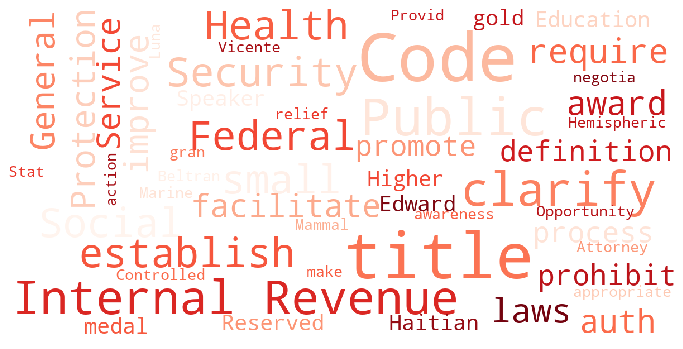

In [27]:
show_wordcloud(df[df['PassH']==0]['combined_text'])


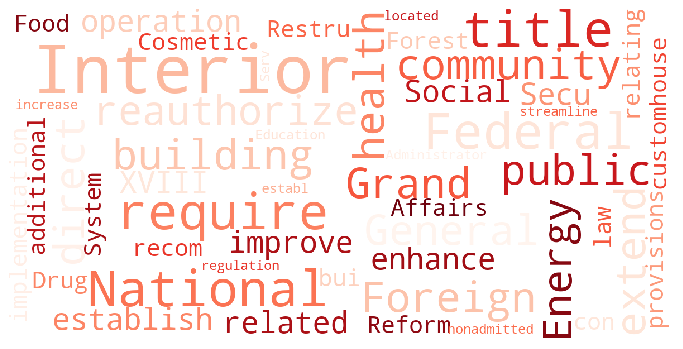

<Figure size 432x288 with 0 Axes>

In [24]:
show_wordcloud(df[df['PassH']==1]['combined_text'])
plt.savefig('WordCloud_Passed.png')

In [55]:
#Wordcloud on difference of frequencies

# Topic Modeling

**Split Training and Testing Data**

In [18]:
from sklearn import preprocessing

In [35]:
from sklearn.model_selection import train_test_split

X = df['combined_text']
y = df['PassH']

X_train, X_test, y_train1, y_test1 = train_test_split(X, y)

In [36]:
df['PassH'].head()

0    1
1    0
2    0
3    0
4    0
Name: PassH, dtype: int64

Encode our target column so that it can be used in machine learning models (may not be necessary since the data is already binary)

In [37]:
encoder = preprocessing.LabelEncoder()

y_train = encoder.fit_transform(y_train1)
y_test = encoder.fit_transform(y_test1)

In [38]:
y_train

array([0, 0, 0, ..., 0, 0, 0])

## Feature Engineering


**Cleaning Text**

Test both the spacy tokenizer and personalized tokenizer against the data.

In [39]:
import spacy
from spacy.lang.en import English
# For part of speech tagging
import en_core_web_sm

nlp = English()
stop_words = spacy.lang.en.stop_words.STOP_WORDS

nlp.Defaults.stop_words |= {"bill","amend", "purpose", "united", "state", "states", "secretary", "act", "federal"}


In [40]:
print(stop_words)

{'may', 'forty', 'cannot', 'as', 'or', 'me', 'anyhow', 'himself', "'m", 'an', 'they', 'whatever', 'all', 'onto', 'why', 'their', 'between', 'side', 'least', 'most', 'after', 'into', 'regarding', 'wherever', '‘m', 'along', 'yourself', 'again', 'even', 'say', 'beyond', 'will', 'various', 'afterwards', 'were', '’s', 'had', 'can', 'ourselves', 're', 'other', 'many', 'such', 'always', 'empty', 'used', 'four', 'both', 'now', 'down', 'nor', 'i', 'in', 'hence', 'just', 'my', 'everything', 'nothing', "'re", '’re', 'someone', 'fifty', 'get', 'him', 'but', 'while', 'herein', '’m', 'above', '’ll', 'over', '‘s', 'although', 'do', 'up', 'amend', 'anything', 'enough', 'upon', 'since', 'of', 'becomes', 'which', 'thence', 'from', 'secretary', 'too', 'some', 'has', 'its', 'n’t', 'every', 'that', 'was', 'well', 'show', 'been', 'whereupon', 'beforehand', 'have', 'third', 'whom', 'front', 'how', 'whither', 'also', 'towards', 'therefore', 'otherwise', 'what', 'elsewhere', 'top', 'often', 'hereupon', 'less',

In [41]:
from spacy.lookups import Lookups
lookups = Lookups()

In [42]:
#Define the spacy tokenizer
spacy_tokenizer = spacy.load('en_core_web_sm', disable =['tagger', 'parser', 'ner'])

In [43]:
import string
import re

replace_with_space = re.compile('[/(){}\[\]\|@,;]')

just_words = re.compile('[^a-zA-Z\s]')


In [44]:
# Create our list of punctuation marks
punctuations = string.punctuation

# Create our list of stopwords
nlp = spacy.load('en_core_web_sm')
stop_words = spacy.lang.en.stop_words.STOP_WORDS

def tokenizer(text):
    
    #lowercase everything
    lower_text = text.lower()
    
    #remove punctuation
#     no_pun_text = lower_text.translate(str.maketrans('', '', string.punctuation))
    
    #get rid of weird characters
    text = replace_with_space.sub('',lower_text)
    
    #remove numbers
    just_words_text = just_words.sub('', text)
    
    #add spacy tokenizer
    mytokens = nlp(just_words_text, disable=['parser', 'ner'])
#     print(mytokens)
    
    #for POS tagging
#     mytokens = [word for word in mytokens if (word.pos_ == 'NOUN') or (word.pos_ == 'VERB') or (word.pos_ == 'ADJ') or (word.pos_ == 'ADV')]
    
    #lemmatize
    mytokens = [word.lemma_.strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]
    
    #MAP SPECIFIC WORDS to others (veteran from veterans)

    #add stopwords
    mytokens = [word for word in mytokens if word not in stop_words and word not in punctuations]
    
    return mytokens
    

In [55]:
test_fun = df.iloc[3486][5]

In [56]:
tokenizer(test_fun)

['title',
 'code',
 'clarify',
 'scope',
 'child',
 'pornography',
 'law',
 'enhance',
 'effective',
 'prosecution',
 'child',
 'pornography',
 'criminal',
 'code',
 'include',
 'child',
 'pornography',
 'activity',
 'production',
 'pornography',
 'importation',
 'predicate',
 'crime',
 'money',
 'laundering',
 'prosecution',
 'define',
 'possess',
 'respect',
 'crime',
 'child',
 'sexual',
 'exploitation',
 'child',
 'pornography',
 'include',
 'accessing',
 'computer',
 'visual',
 'depiction',
 'child',
 'pornography',
 'intent',
 'view']

In [53]:
tokenize(X)

['provide',
 'implementation',
 'recommendation',
 'national',
 'commission',
 'terrorist',
 'attack',
 'implement',
 'recommendation',
 'commission',
 'provide',
 'implementation',
 'recommendation',
 'national',
 'commission',
 'terrorist',
 'attack',
 'commission']

In [15]:
#testing lemmatizer

test_fun = df.iloc[3486][5]

mytokens = nlp(test_fun)

tokens = []
for word in mytokens:
    if word.lemma_ != "-PRON-":
        tokens.append(word.lemma_.lower().strip())
    else:
        tokens.append(word.lower_)
        
tokens

NameError: name 'nlp' is not defined

In [ ]:
mytokens

**Quick EDA on Tokenized Text**

In [71]:
! pip install counter

In [72]:
all_lemmas = df.combined_text.apply(tokenizer)

In [73]:
all_lemmas.head()

0    [provide, implementation, recommendation, nati...
1                                   [reserve, speaker]
2    [high, education, prevent, veteran, contributi...
3    [award, congressional, gold, medal, edward, wi...
4    [haitian, hemispheric, opportunity, partnershi...
Name: combined_text, dtype: object

In [74]:
len(all_lemmas)

51067

In [75]:
lemma_length = [len(set(lemmas)) for lemmas in all_lemmas]

In [76]:
df['lemmas'] = all_lemmas

In [77]:
df['lemma_length'] = lemma_length

In [78]:
df.head()

,BillID,Title,Summary,PassH,Cong,combined_text,lemmas,lemma_length
0,110-HR-1,To provide for the implementation of the recom...,Implementing Recommendations of the 9/11 Commi...,1,110,To provide for the implementation of the recom...,"[provide, implementation, recommendation, nati...",8
1,110-HR-10,Reserved for Speaker.,,0,110,Reserved for Speaker.,"[reserve, speaker]",2
2,110-HR-100,To amend the Higher Education Act of 1965 to p...,Veterans' Equity in Education Act of 2007 - Am...,0,110,To amend the Higher Education Act of 1965 to p...,"[high, education, prevent, veteran, contributi...",32
3,110-HR-1000,To award a congressional gold medal to Edward ...,Edward William Brooke III Congressional Gold M...,0,110,To award a congressional gold medal to Edward ...,"[award, congressional, gold, medal, edward, wi...",19
4,110-HR-1001,To amend the Haitian Hemispheric Opportunity t...,Amends the Caribbean Basin Economic Recovery A...,0,110,To amend the Haitian Hemispheric Opportunity t...,"[haitian, hemispheric, opportunity, partnershi...",27


Text(0.5, 1.0, 'Lemma Length by Congress = Not Pass and Pass House')

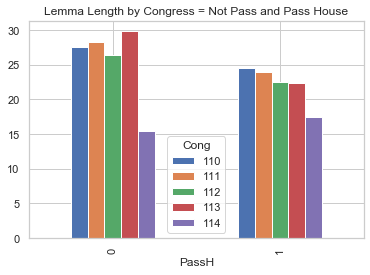

In [79]:
import seaborn as sns
sns.set(style="whitegrid")

df.groupby(['PassH','Cong'])['lemma_length'].agg('mean').unstack().plot.bar().set_title('Lemma Length by Congress = Not Pass and Pass House')

In [100]:
df['lemma_length'].median()

23.0

In [80]:
total_lemmas = []
for doc in all_lemmas:
    total_lemmas.extend(doc)

In [81]:
len(total_lemmas)

1926293

In [82]:
from collections import Counter

all_words = dict(Counter(total_lemmas))

In [83]:
fewest_words = {key: value for key, value in all_words.items() if value < 100}


In [84]:
more_words = {key: value for key, value in all_words.items() if value >= 50}

In [85]:

# plt.bar(range(len(more_words)), list(more_words.values()), align='center')
# plt.xticks(range(len(more_words)), list(more_words.keys()))
# plt.rcParams["figure.figsize"] = [20,9]
# # # for python 2.x:
# # plt.bar(range(len(D)), D.values(), align='center')  # python 2.x
# # plt.xticks(range(len(D)), D.keys())  # in python 2.x

# plt.show()

In [143]:
#Dataframe of lemmas
lemma_df = pd.DataFrame.from_dict(more_words, orient='index', columns=['count'])
lemma_df = lemma_df.reset_index()
lemma_df.head()

,index,count
0,provide,20851
1,implementation,913
2,recommendation,671
3,national,13463
4,commission,3347


In [86]:
#review of the top words
for word in sorted(more_words, key=more_words.get, reverse=True):
    print(word, more_words[word])

provide 20851
program 18729
service 17856
health 15658
require 15317
code 14711
national 13463
certain 12512
security 12150
title 10922
establish 10223
revenue 9942
tax 9849
internal 9526
duty 9307
direct 9260
use 9048
public 8286
education 8243
authorize 7849
care 7846
include 7529
extend 7263
individual 7222
grant 6978
credit 6813
agency 6731
year 6629
energy 6604
assistance 6533
department 6368
protection 6243
prohibit 6158
social 6148
fund 5691
veteran 5667
system 5507
business 5487
allow 5479
increase 5306
employee 5258
land 5242
law 5215
measure 5194
member 5037
requirement 5007
child 4903
temporarily 4766
information 4706
plan 4607
benefit 4577
medicare 4555
development 4512
improve 4448
schedule 4417
government 4412
relate 4304
facility 4287
suspend 4241
school 4235
area 4200
insurance 4189
tariff 4096
income 4073
water 4054
small 4035
respect 4020
research 3956
payment 3917
harmonized 3902
provision 3782
report 3776
office 3760
drug 3735
local 3711
veterans 3710
property 3631


initiate 174
generic 174
specialty 174
earning 174
radio 174
instruct 173
drilling 173
copyright 173
jersey 173
ohio 173
reorganization 173
guantanamo 173
arctic 173
counsel 172
kid 172
iraqi 172
nationwide 172
ester 172
rescind 172
guam 171
quantity 171
examine 171
metropolitan 171
cut 170
plus 170
steel 170
placement 170
pose 170
minnesota 170
elderly 170
sharing 170
injure 170
defer 170
consolidate 170
safeguard 169
pennsylvania 169
pregnant 169
birth 169
search 169
andor 169
filing 169
protective 168
disposition 168
length 168
fraudulent 168
tanf 168
utilization 167
pollutant 167
remedy 167
element 167
representation 167
teach 167
vaccine 167
doj 167
tarp 167
lender 166
comprise 166
samoa 166
faa 166
fda 166
geographic 166
expire 166
rescue 165
sentence 165
truck 165
equitable 165
trauma 165
telecommunications 165
rebate 165
textile 165
cyber 165
medication 165
meeting 164
knowledge 164
wastewater 164
supplementary 164
burden 163
wait 163
reasonably 163
korea 163
separation 163
cur

drugfree 55
compatible 55
ha 55
following 55
pressure 55
printing 55
roth 55
comparative 55
radioactive 55
sewer 55
hostile 55
importance 55
nhtsa 55
aerial 55
refinancing 55
glass 55
lieutenant 55
onshore 55
explosion 55
football 55
heater 55
ehr 55
palliative 54
antidumpe 54
cord 54
ambassador 54
conditional 54
exit 54
statue 54
punishment 54
landowner 54
chiropractic 54
lawrence 54
deferral 54
subcontract 54
sand 54
selfemployed 54
bundle 54
joseph 54
levy 54
fisheries 54
holding 54
privately 54
scale 54
prepaid 54
forprofit 54
nazi 54
regulator 54
reactor 54
advisability 54
yttrium 54
acetic 54
insulation 54
postage 53
generationskippe 53
confidence 53
son 53
daughter 53
passive 53
pathogen 53
phaseout 53
accommodate 53
clothing 53
combatrelate 53
refusal 53
tollfree 53
alleviate 53
martin 53
accurately 53
nutrient 53
graze 53
interoperable 53
alliance 53
extraction 53
mentally 53
roadless 53
sunshine 53
billing 53
readjustment 53
subsection 53
platform 53
willfully 53
disregard 53

In [87]:
#review of the fewest words
for word in sorted(fewest_words, key=fewest_words.get, reverse=True):
    print(word, fewest_words[word])

suitable 99
george 99
sanctuary 99
blood 99
infection 99
canyon 99
warrior 99
paul 99
dr 99
domain 99
procure 99
reemployment 98
widow 98
prompt 98
tourism 98
publicprivate 98
eg 98
combatant 98
levee 98
accelerated 98
cross 98
married 98
inmate 98
telecommunication 98
merchandise 98
thermal 98
concentration 97
harmful 97
come 97
mutual 97
vii 97
constitutional 97
tennessee 97
revision 97
extreme 97
intellectual 97
aids 97
choose 97
proper 97
purchaser 97
cent 97
dispose 97
town 97
beverage 97
chip 97
loophole 97
liquidation 97
cocaine 97
solicitation 96
improved 96
patrol 96
fruit 96
tract 96
maximize 96
hb 96
telehealth 96
lawsuit 96
behavior 96
setting 96
decedent 96
refuse 96
pigment 96
usp 96
forces 95
newborn 95
faith 95
invasive 95
uranium 95
especially 95
abandon 95
earthquake 95
liquid 95
package 95
eesa 95
legally 94
lack 94
communitybased 94
plugin 94
outlay 94
nonresident 94
democratic 94
liquefy 94
withholding 94
indirect 94
computation 94
korean 94
minimize 94
pathway 94


counter 61
parole 61
tissue 61
marketplace 61
residual 61
dimethyl 61
purple 60
recapture 60
continuity 60
ambulatory 60
deportation 60
arthritis 60
alleged 60
entertainment 60
retrain 60
g 60
maine 60
handling 60
superior 60
incarceration 60
lifelong 60
haven 60
draft 60
clearance 60
amtrak 60
preexisting 60
overthecounter 60
chair 60
employmentbased 60
spin 60
destination 60
diplomacy 59
steam 59
holocaust 59
inactive 59
surgery 59
debris 59
shipment 59
interfere 59
sexually 59
corrective 59
satisfaction 59
accredited 59
al 59
play 59
malpractice 59
stream 59
additive 59
selfsufficiency 59
carryback 59
marshal 59
powder 59
millimeter 59
caribbean 58
manipulation 58
abduction 58
farmland 58
methane 58
willing 58
fundamental 58
sacramento 58
benchmark 58
adjudication 58
sample 58
rollover 58
brand 58
negative 58
headquarters 58
wasteful 58
ice 58
reaction 58
testimony 58
marshall 58
depict 58
bullying 58
ozone 58
nrc 58
maternity 58
outline 57
vicinity 57
riverside 57
coral 57
charity 

fugitive 32
targeting 32
watch 32
electromagnetic 32
nomination 32
euca 32
coat 32
ac 32
crimp 32
zika 32
businessrelated 31
subchapter 31
reunification 31
surrender 31
felon 31
pps 31
biomarker 31
cia 31
yearround 31
pandemic 31
toxin 31
motorsport 31
assert 31
foia 31
oath 31
urgent 31
tiger 31
enrichment 31
hub 31
nd 31
apr 31
credible 31
wholesale 31
undocumented 31
coinsurance 31
avalanche 31
induce 31
pistol 31
pierce 31
probable 31
infantry 31
customary 31
pastdue 31
prosthesis 31
muscogee 31
predatory 31
allergy 31
characterization 31
omission 31
clearing 31
dentist 31
hivaids 31
mix 31
accumulate 31
se 31
true 31
semester 31
highlevel 31
kidnapping 31
interaction 31
eradicate 31
concentrate 31
density 31
microloan 31
roosevelt 31
immunosuppressive 31
wide 31
retransmission 31
searchable 31
wilberforce 31
pledge 31
square 31
button 31
divinylbenzene 31
tetrafluoroethylene 31
perfluorocarbon 31
connector 31
imidacloprid 31
unwarranted 31
swine 31
ultimate 31
overdraft 31
mom 31


unusual 20
neonatal 20
usfws 20
incompetent 20
taos 20
novel 20
mammogram 20
mendocino 20
photovoltaic 20
selfemploye 20
technologically 20
uptodate 20
sos 20
passthrough 20
fairly 20
paincapable 20
christian 20
expedition 20
archer 20
fractional 20
amortize 20
unjust 20
unconstitutional 20
boxer 20
works 20
innovator 20
entrance 20
soda 20
shape 20
matthew 20
tube 20
inert 20
dedication 20
propylene 20
heptanoate 20
diethyl 20
fiberglass 20
propyl 20
mefenoxam 20
underwrite 20
tris 20
borlaug 20
jewelry 20
fitting 20
beetle 20
bradley 20
digitaltoanalog 20
abolishment 20
super 20
exoffender 20
timeline 20
durban 20
bush 20
parks 20
inyo 20
megawatt 20
employersponsored 20
infringe 20
nepal 20
evacuee 20
constitutionality 20
allinclusive 20
postkatrina 20
competency 20
texoma 20
ric 20
nutritious 20
contravention 20
drunk 20
bpa 20
decisionmaking 20
coach 20
prescribing 20
spencer 20
replicate 20
intimate 20
guideway 20
scrutiny 20
informant 20
gsp 20
satisfie 20
reckless 20
bls 20
bel

perish 12
maltreated 12
interception 12
vend 12
diversify 12
teletypewriter 12
reconnaissance 12
pow 12
insider 12
reservists 12
rancho 12
fehb 12
unremarried 12
gynecologic 12
swimming 12
boating 12
rochester 12
harrison 12
attention 12
ihs 12
concise 12
lasting 12
idling 12
foods 12
identical 12
deteriorate 12
reed 12
housingrelate 12
increment 12
acupuncturist 12
esther 12
karinge 12
breakdown 12
elemental 12
multisite 12
difficult 12
lawabide 12
shipbuilding 12
ez 12
fafsa 12
ordinance 12
detrimental 12
deformity 12
baca 12
heroic 12
revolution 12
honey 12
experimentation 12
walk 12
wing 12
medpac 12
moore 12
postgraduate 12
tooth 12
sealant 12
phasedin 12
menopausal 12
fueled 12
americare 12
anesthesiology 12
panama 12
cloud 12
palm 12
elapse 12
rockie 12
philanthropy 12
warner 12
deer 12
reparation 12
midshipman 12
inappropriately 12
robust 12
arenas 12
btu 12
noncorporate 12
silicate 12
locatable 12
haul 12
refiner 12
peerreviewed 12
columbus 12
mailorder 12
retaliate 12
issuing

ramos 8
ortho 8
oilproduce 8
portage 8
embezzlement 8
renegotiation 8
fernando 8
inschool 8
stipulation 8
architecture 8
willamette 8
lowerincome 8
deceptively 8
tulare 8
psychiatry 8
segregation 8
obverse 8
tsp 8
greece 8
signatory 8
brigade 8
suggestion 8
dyslexia 8
apalachicola 8
keeping 8
clyde 8
ouachita 8
safetyrelated 8
resonance 8
allurban 8
sox 8
hoursofservice 8
biobased 8
internetbase 8
vaccinate 8
nonregulate 8
perio 8
rey 8
adulteration 8
umbrella 8
dgme 8
medicarecovered 8
potws 8
nonmailable 8
elevator 8
eurasia 8
incitement 8
buren 8
dissolution 8
patsy 8
mink 8
parte 8
inaccessible 8
antigang 8
healthier 8
statefunde 8
sebastian 8
nanomanufacture 8
hugh 8
courtappointe 8
pajarita 8
tumacacori 8
excessively 8
subwatershe 8
molokai 8
pharmacological 8
ginseng 8
egs 8
consultative 8
codification 8
predetermine 8
milepost 8
trio 8
upward 8
louisville 8
bountiful 8
precondition 8
verifiable 8
auditable 8
detat 8
researchbased 8
escalation 8
defined 8
turnabout 8
escalante 8

cytological 6
accrediting 6
winston 6
weighted 6
lost 6
olivet 6
reasonableness 6
inhuman 6
compelling 6
zdenko 6
lisak 6
caregiving 6
binding 6
helm 6
inaccessibility 6
postabortion 6
fauna 6
flora 6
healthful 6
leach 6
lessor 6
lumen 6
elvira 6
intelligent 6
happen 6
reaffirmation 6
fivedollar 6
iraqs 6
hermitage 6
poland 6
stb 6
outbound 6
fortification 6
coushatta 6
spence 6
swim 6
privileged 6
substandard 6
carie 6
roads 6
activation 6
philip 6
sweetwater 6
norwood 6
implantable 6
onefamily 6
alleviation 6
refrigeration 6
antigun 6
retraining 6
federallyguaranteed 6
amache 6
pecan 6
optometric 6
minorityowned 6
consumers 6
confiscation 6
embody 6
determinant 6
hass 6
servicewoman 6
countable 6
profitability 6
player 6
miamisburg 6
davalos 6
rangel 6
advertiser 6
interestbearing 6
twelfth 6
reno 6
configuration 6
tetra 6
selfinitiation 6
federallyqualifie 6
mille 6
lacs 6
respectful 6
uterine 6
medikids 6
bald 6
potholes 6
foregoing 6
colocate 6
johannas 6
motorist 6
intracompany 6

fivemember 6
undiscovered 6
alhousseynou 6
marti 6
hometown 6
recharging 6
animalbased 6
tripoli 6
altamont 6
maintaining 6
egyptisrael 6
shot 6
bullet 6
gallium 6
ewa 6
mozdzen 6
partisan 6
cpra 6
nics 6
enjoin 6
vascular 6
gasparilla 6
geolocational 6
studys 6
sigma 6
paralympics 6
transuranic 6
logical 6
circumcision 6
statistically 6
powderhorn 6
harvester 6
placard 6
onslow 6
surf 6
remarkable 6
splitinter 6
grantmake 6
lori 6
wallow 6
pascua 6
yaqui 6
mete 6
consensual 6
educating 6
grizzly 6
waterways 6
arrm 6
mainly 6
foreclosedupon 6
prenda 6
potw 6
signify 6
walkin 6
tuf 6
shur 6
bien 6
publicity 6
sprint 6
shakeel 6
nucleararmed 6
ceremonial 6
lp 6
postmark 6
nicklaus 6
althea 6
blas 6
fomc 6
quiet 6
demolish 6
wagnerpeyser 6
benzenesulfonyl 6
transportationoriente 6
teller 6
configure 6
adls 6
pyraflufenethyl 6
rooftop 6
audiovisual 6
prothioconazole 6
carpet 6
cooker 6
ethenylbenzene 6
picoxystrobin 6
tertiobutyl 6
catechol 6
dgalactodmannan 6
tracts 6
casting 6
ethenyleth

aa 4
sufficiency 4
repeated 4
overvalue 4
percy 4
statusrelate 4
horn 4
sensibility 4
meanstest 4
universitybased 4
exonerees 4
enron 4
rrustem 4
neza 4
columbiapacific 4
fagans 4
monograph 4
charitys 4
remedies 4
antitorture 4
dim 4
tragic 4
juanita 4
millendermcdonald 4
ataa 4
ta 4
personhood 4
braille 4
uocava 4
foaram 4
running 4
cylinder 4
vfa 4
antibioticresistant 4
bacteria 4
bestpractice 4
congressionalexecutive 4
marketdriven 4
spice 4
nonalcoholic 4
lakewood 4
facilitys 4
tampa 4
epilink 4
propionate 4
becker 4
resemble 4
southpark 4
ponce 4
tof 4
dpk 4
dimethoxybutanone 4
cyanopyridine 4
benfluralin 4
dmds 4
dimethylimidazolidinone 4
mcpa 4
fenbuconazole 4
ethalfluralin 4
tebufenozide 4
quintec 4
myclobutanil 4
methoxyfenozide 4
dichloropropene 4
trifluralin 4
cl 4
diiodomethylptolylsulfone 4
depct 4
tebuthiuron 4
thiophenediylbisdimethylethyl 4
mda 4
nourybond 4
modifi 4
triol 4
fertilizer 4
cdcs 4
hardtofill 4
biaxially 4
dielectric 4
norbloc 4
hydroxypropylmethylcellulose

saracini 4
deyarmin 4
dreissena 4
quagga 4
genderresponsive 4
hyperbaric 4
courtsmartial 4
fullyintegrate 4
aif 4
qip 4
asthmarelate 4
ccrs 4
moe 4
ambush 4
lanai 4
capitate 4
musial 4
algorithmic 4
sinai 4
oakdale 4
perseverance 4
antirocket 4
sling 4
uncontrollable 4
patronizing 4
reroute 4
interconnectedness 4
biggertwaters 4
contrast 4
debilitate 4
unleash 4
holland 4
gallantry 4
tideland 4
maude 4
frazier 4
capt 4
goetz 4
taiwans 4
preflood 4
cynthia 4
haiyan 4
mileagebased 4
acknowledgement 4
libertyhurriya 4
reimporte 4
nonenforcement 4
vizguerraramirez 4
kemboi 4
basement 4
openly 4
fluke 4
multimillion 4
reproducible 4
legalize 4
apostle 4
neurotechnologie 4
battlespace 4
stain 4
overlook 4
offenders 4
extensible 4
antigovernment 4
kca 4
repurposing 4
copperas 4
limousine 4
pierre 4
lenfant 4
nonlocke 4
ntis 4
interring 4
statesisraeli 4
antonia 4
aguilar 4
belmontes 4
subjective 4
aligned 4
psdar 4
residentialzone 4
apnea 4
centrocercus 4
montauk 4
obligatory 4
meriam 4
yahya

stanley 3
compressor 3
preferably 3
postfire 3
substation 3
underscore 3
zebulon 3
bellefontaine 3
natchitoche 3
hotspot 3
dataset 3
gratitude 3
erin 3
dowry 3
sunsets 3
interlocutory 3
pic 3
lrtap 3
geoscience 3
radiator 3
spoil 3
depositing 3
binghamton 3
eternal 3
expired 3
alchol 3
swipe 3
cannabimimetic 3
analytic 3
misvalue 3
analogous 3
destabilize 3
ingenuity 3
constructive 3
slag 3
steppedup 3
reproduce 3
exhume 3
outset 3
counterparty 3
div 3
commodities 3
watertrails 3
porcupine 3
detoxification 3
nonindustrial 3
distracted 3
albans 3
bluefin 3
mwaa 3
damaged 3
selfharm 3
orthotist 3
prosthetist 3
essentially 3
customfitte 3
customfabricated 3
goodall 3
rescheduling 3
profitable 3
noncampus 3
dualenergy 3
nondischargeability 3
accomack 3
heros 3
taxdeductible 3
derek 3
hodge 3
corebased 3
gene 3
abcs 3
unmarked 3
nab 3
strategie 3
legion 3
forb 3
para 3
suite 3
disembark 3
exemplify 3
returnfree 3
economics 3
fuse 3
higherorder 3
numeral 3
silviculture 3
venezuelas 3
desc 3


hydroxyhyroxymethylmethyl 2
isocyanatoisocyanatomethyltrimethylcyclohexan 2
orthonitrophenol 2
mpdc 2
methylbenzonitrile 2
trifluoromethoxy 2
propanephosphonic 2
wg 2
trichloroacetaldehyde 2
methylsulfonyltrifluoromethylbenzoylcyclopropyl 2
soxazole 2
crackcocaine 2
ethoprop 2
foramsulfuron 2
iodosulfuronmethylsodium 2
erpa 2
ethylenenorbornene 2
methoxycinnamate 2
enychlorothiazolyl 2
methylnmethylyoxidooxohydrazono 2
methanediamine 2
nychlorothiazolylmethylnemethylamino 2
yoxidooxohydrazono 2
methylamine 2
methylthiotrifluoromethyl 2
mesityloxooxaspiroynonenyl 2
dimethylbutyrate 2
ethoxydihydrodiemthylbenzofuranyl 2
methansulfonate 2
ymethoxymethyloxodihydrohtria 2
zolylcarbonylamino 2
sulfonylmethylthiophenecaroxylate 2
dihydrodiphenyloxazolecarboxylate 2
isoxaflutolecyclospropylmethylsulfonyltrifluorom 2
ethylbenxoylisoxazole 2
ipn 2
isophthalonitrile 2
nyoxoimidazolidineylethylmethylacrylamide 2
oxa 2
diazadispiro 2
heneicosanone 2
tetramethyl 2
epichlorohydrin 2
broth 2
split 2
t

bicorr 2
coflake 2
giardiniera 2
sensitizing 2
technicalchlorondinitrotrifluoromethylphenylnethylfluorobenzenemethanamine 2
chlorodinitrobenzotrifluoride 2
chromatography 2
pyraflufen 2
hydroxydodecyloxyproploxyhydroxphenylbisdimethylphenyltriazine 2
hydroxytridecyloxypropyloxyhydroxyphenylbisdemethylphenyltriazine 2
polytetramethylbutylaminotriazinediyl 2
tetramethylpiperidinylinimohexanediyltetramethylpiperidinylimino 2
bistetramethylpiperidyl 2
sebacate 2
diisopropyl 2
succinate 2
pchloroaniline 2
buprofizen 2
isocyanatosulfonylbenzoic 2
bromochlorochloropyridylmethylmethylcarbamoylpyrazolecarboxanilide 2
schloroamethylethyl 2
benzeneacetate 2
acai 2
uncooked 2
boil 2
swag 2
mini 2
stereo 2
kw 2
morpholine 2
transducer 2
chloropyridinylmethlynnitroimidazolidinimine 2
rcyanofluorophenoxylphenylmethyl 2
rrdichloroethenyldimethylcyclopropanecarboxylate 2
tripropyltrioxatriphosphinane 2
trioxide 2
nitroguanidine 2
guanidine 2
doublefan 2
singlefan 2
fanmotor 2
schloroamethylethylbenzene

amberwood 2
hetoate 2
ml 2
menthold 2
heliopan 2
hexyl 2
caproate 2
methylylbenzyl 2
salicilate 2
dichlorodiphenylsulfone 2
neononyl 2
phenylethyl 2
isobutyrate 2
majantol 2
cheat 2
agrumex 2
chlorotrifluoro 2
vinylidine 2
mefenpyr 2
propoxycarbazonesodium 2
diethylene 2
divinyl 2
stablilizer 2
toe 2
slipon 2
visns 2
bihindolediol 2
dihydroxynitro 2
phenylamino 2
cyano 2
methoxybenzothiazoylaminohisoindol 2
ylidene 2
aminohydroxymethoxysulfooxyethylsulfonylphenyldiazenyl 2
aminohydroxybixsulfooxyethyl 2
sulfonylphenyldiazenyl 2
mixure 2
hydroxykohydroxykonaphthalenyldiazenylknnaphtalenesulfonatohydroxykomethyoxyphenyldiazenylphenyldiazenylknnaphtalenolatokosodium 2
bisaminosulfonylhydroxykophenyldiazenylknoxokonphenylbutanamidato 2
mixturesof 2
bishydroxykooxokopheylamino 2
hydroxyko 2
oxokophenylamino 2
hydroxykophenylamino 2
sulfony 2
oxokonphenylbutanamidato 2
dinitrothienyldiazenylphenyliminobis 2
carbonylbisiminophenylenediazenydiylbisaminohydroxyphenyldiazenyl 2
bishydroxyk 2
ohy

radioisotopic 2
bici 2
dischargeable 2
jefeti 2
exportrelated 2
aramid 2
pureed 2
doppl 2
ohv 2
miningrelated 2
financier 2
surprise 2
livein 2
cradle 2
musselshelljudith 2
indicative 2
areawide 2
yazidis 2
surveil 2
flamethrower 2
orca 2
mindset 2
nhsc 2
simcakoski 2
masaryk 2
theoretical 2
capabilities 2
kennewick 2
archeology 2
terroristcontrolle 2
apologize 2
lwcf 2
multiline 2
dial 2
prefix 2
postfix 2
karis 2
oriental 2
customerside 2
paccandidate 2
ayatollah 2
villatoros 2
bja 2
conran 2
dillingham 2
cbcr 2
russianbacke 2
bloody 2
cremated 2
bikeshare 2
selfschedule 2
cosby 2
westland 2
joanne 2
herring 2
discoverability 2
cheney 2
mails 2
marginalize 2
albatross 2
petrel 2
myra 2
painrelate 2
headgate 2
biographical 2
investmentrelate 2
bds 2
earlylearne 2
rightsized 2
cumbersome 2
flagstaff 2
radiographer 2
hallway 2
eastvale 2
myung 2
mok 2
kei 2
za 2
ryu 2
kathmandu 2
hangup 2
adrenoleukodystrophy 2
aidans 2
merrills 2
beacon 2
caring 2
unsubscribe 2
motorsports 2
rpm 2
comp

chemicalfacility 1
gallbladder 1
nsca 1
rept 1
xliv 1
foreclosuremitigation 1
alabamacoosatallapoosa 1
militaryrelated 1
basisand 1
insurancerelate 1
primarycare 1
reregister 1
reregistration 1
seminole 1
charlottesville 1
postlegal 1
nationallyavailable 1
unanticipate 1
youthserve 1
providerspecific 1
brutalize 1
sudans 1
repress 1
chine 1
beijing 1
whiskeytownshastatrinity 1
multnomah 1
whiskeytownshasta 1
handmade 1
legibly 1
fullsize 1
nonfullsize 1
broken 1
blogger 1
blog 1
splash 1
organziation 1
mize 1
hoursaday 1
offexchange 1
ybarra 1
foreclosed 1
forestall 1
publicallyavailable 1
shrub 1
vegetated 1
pasture 1
arraignment 1
bioluminescent 1
martintravis 1
dodson 1
adjudicatory 1
undergoe 1
militaryissued 1
clarita 1
ecotourism 1
stateadministere 1
foodrelated 1
weaponsrelate 1
spillover 1
advancable 1
healthmart 1
iraqisupported 1
radiationmeasurement 1
lessthanhalftime 1
rodney 1
presumtion 1
invidiual 1
airportrisk 1
occupany 1
militarycivilian 1
chargerelated 1
reserved 1
c

childproof 1
ogallala 1
peracre 1
transdisciplinary 1
blanchard 1
mower 1
nonvehicular 1
reliabilit 1
stateapproved 1
gu 1
candelabra 1
commerciallymarkete 1
oddnumbered 1
nondeductible 1
endofyear 1
exemptinter 1
parkpropose 1
inspecting 1
erulemake 1
nonpollock 1
maxwell 1
cirminal 1
striking 1
indefiniteness 1
insufficiency 1
unmeritorious 1
swierkiewicz 1
sorema 1
leatherman 1
tarrant 1
bnaf 1
cgsc 1
flea 1
weans 1
diversifying 1
pesticiderelated 1
stockholm 1
rotterdam 1
giawatt 1
kikai 1
seisakusho 1
geosciences 1
reinstating 1
timecomputation 1
dormancy 1
perindividual 1
intranet 1
nesa 1
cybersecurityrelate 1
rapanos 1
mscm 1
honoliuli 1
nondiscretionary 1
cou 1
wwwrecallsgov 1
preforeclosure 1
culpable 1
stateowned 1
strictly 1
feeling 1
regret 1
ongoe 1
earnedvalue 1
rebaseline 1
shampoo 1
bath 1
lipstick 1
wipe 1
buzz 1
aldrin 1
lafollette 1
deidentified 1
nonaggregate 1
deidentifie 1
msis 1
employedprovide 1
certiori 1
councils 1
frankfurt 1
fimba 1
discredit 1
ceq 1
eiss 1

cab 1
uniquely 1
headquarte 1
alphaphenylpiperdylacetic 1
tripehnylmethane 1
traiff 1
biphenyldiamino 1
suspsension 1
committess 1
hydroxymethacrylyloxyethylphenyl 1
methacrylyloxyethylphenyl 1
resubordinate 1
bischlorohydroxylophenyldiazenylkndihydromethylo 1
bischlorohydroxylophenyldiazenylkndihydromethyloxokohpyrazolylbenzenefulfonamidato 1
substitutedtriazinylaminohydroxysulfophenylsubstitutedazo 1
substitutedtriazinylamino 1
hydroxysulfophenyl 1
substitutedazo 1
hasrequeste 1
genderspecific 1
barona 1
entrepreneurs 1
edps 1
tenancy 1
expatriot 1
emtb 1
technicianparamedic 1
mansfield 1
winder 1
pusuant 1
divisional 1
damag 1
battin 1
tend 1
decorating 1
pneumoccal 1
initiates 1
taas 1
hat 1
bequeath 1
remarrie 1
cci 1
outcomebase 1
incentivesbase 1
bowman 1
lawsu 1
constructionrelate 1
sigar 1
rite 1
fvisa 1
mvisa 1
telemarkete 1
hivpositive 1
kling 1
sizing 1
authorizations 1
pascagoula 1
nibtas 1
npl 1
cislunar 1
throttling 1
broader 1
worstcasescenario 1
sch 1
psychosocial 1
re

honorability 1
requests 1
grogan 1
dressing 1
yugoslavia 1
rinseoff 1
intentionallyadde 1
bonuses 1
antitunnele 1
antitunnel 1
armorpierce 1
eightyearold 1
rays 1
seso 1
reassure 1
rails 1
janes 1
whiting 1
galvanize 1
boondoogle 1
tab 1
farther 1
cram 1
floodgate 1
iprotecte 1
nonbiologic 1
sorghum 1
antiresale 1
extraterritoriality 1
carder 1
agile 1
nonduty 1
tampico 1
refunds 1
nolan 1
enslave 1
moses 1
marcel 1
notzon 1
institutionalize 1
shutdowns 1
abuses 1
wideband 1
nationallyrecognized 1
meritreviewed 1
useinspired 1
quanta 1
mesoscale 1
selffunde 1
nongrandfathere 1
nonwillful 1
unrepeated 1
nonserious 1
furthermore 1
fracke 1
overregulation 1
imd 1
antiswatte 1
referenda 1
chokehold 1
deeming 1
bearss 1
storytelling 1
nonformulary 1
cablecaste 1
asurface 1
ifederalaid 1
aauthorization 1
surfa 1
weinstein 1
transload 1
coachonly 1
knocks 1
oneforone 1
strategically 1
icdten 1
siteofservice 1
slapp 1
lunette 1
bourbon 1
reexporte 1
psi 1
continual 1
allyear 1
welldocumente 1


**CountVectorizer**

Every row represents a document in the corpus, every column represents a term in the document, every cell represents the frequency count of a particular term in a particular document.

Tuning: analyzer, vectorizer, max_features, max_df, min_df, n_grams

Explore:

min_df:

- min_df = 0.01 means "ignore terms that appear in less than 1% of the documents".
- min_df = 5 means "ignore terms that appear in less than 5 documents".

max_df: Attempt to remove heavily used words.

- max_df = 0.50 means "ignore terms that appear in more than 50% of the documents".
- max_df = 25 means "ignore terms that appear in more than 25 documents".

In [35]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(tokenizer = tokenizer, max_df = 0.90, max_features = 10000) # max_df=0.90, min_df=10
transformed = vectorizer.fit_transform(X_train, y_train)
print(len(vectorizer.get_feature_names()))

10000


**Exploring Stored Words**

Think about the number of words and how to decrease that list!

Lemmatization should be something to further consider, also limiting specific words (pronouns?) used often

In [36]:
len(vectorizer.get_feature_names())

10000

In [37]:
vectorizer.get_feature_names()[:100] #[200:300]

['aaron',
 'abandon',
 'abandonment',
 'abate',
 'abatement',
 'abbreviate',
 'abdoul',
 'abduct',
 'abducted',
 'abduction',
 'aberdeen',
 'abet',
 'ability',
 'able',
 'abnormal',
 'abnormality',
 'aboard',
 'abode',
 'abolish',
 'abolishment',
 'abolition',
 'aboriginal',
 'abortion',
 'abortionrelated',
 'aboveground',
 'abovetheline',
 'abraham',
 'abridge',
 'abridgment',
 'abroad',
 'abrogate',
 'absence',
 'absent',
 'absentee',
 'absorptiometry',
 'abstinence',
 'abstinenceonly',
 'abundance',
 'abundant',
 'abuse',
 'abused',
 'abuser',
 'abusive',
 'abut',
 'ac',
 'aca',
 'academia',
 'academic',
 'academically',
 'academy',
 'acadia',
 'accelerate',
 'accelerated',
 'acceleration',
 'accelerator',
 'accept',
 'acceptable',
 'acceptance',
 'access',
 'accessibility',
 'accessible',
 'accession',
 'accessory',
 'accident',
 'accidental',
 'accommodate',
 'accommodation',
 'accompany',
 'accomplish',
 'accomplishment',
 'accord',
 'accordance',
 'accordingly',
 'account',
 'ac

In [38]:
import random

#get ten random words from each

for i in range(10):
    word_id = random.randint(0, 2454) #second should be len of cv
    print(vectorizer.get_feature_names()[word_id])

construe
abraham
carolina
biodefense
crossborder
dayton
antidope
arizona
ana
defined


**Topic - Modeling LDA**


LDA is an iterative model which starts from a fixed number of topics. Each topic is represented as a distribution over words, and each document is then represented as a distribution over topics.

https://stackabuse.com/implementing-lda-in-python-with-scikit-learn/

In [39]:
from sklearn.decomposition import LatentDirichletAllocation

In [40]:
# # Build LDA Model
# # focus on number topics, max iteration, learning decay

# lda_model = LatentDirichletAllocation(n_components=13,               # Number of topics 
#                                       learning_decay=0.4,    # Max learning iterations (how many times going over whole dataset)
#                                       random_state=42,          # Random state
#                                       n_jobs = -1,               # Use all available CPUs
#                                      )

# print(lda_model)  # Model attributes

In [41]:
# # This can take awhile, we're dealing with a large amount of documents!

# lda_output = lda_model.fit_transform(transformed)


**OPTIONAL - Grisearch LDA**

In [64]:
from sklearn.model_selection import GridSearchCV


# Define Search Param
search_params = {'n_components': [12, 13],
                 'learning_decay': [.3, .4]
                }

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params, cv=3, verbose=2, n_jobs = -1)

# Do the Grid Search
model.fit(transformed)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 16.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 16.7min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='batch',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                                 total_s

In [65]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(transformed))

#Shows best params
#shows best log likelihood
#shows model perplexity score

Best Model's Params:  {'learning_decay': 0.3, 'n_components': 13}
Best Log Likelihood Score:  -3358766.209052358
Model Perplexity:  971.0639858461641


**Gridsearch 1**: 
- Best Model's Params:  {'learning_decay': 0.5, 'n_components': 15}
- Best Log Likelihood Score:  -751642.0137549518
- Model Perplexity:  921.196053929341

**Gridseach 2**:
-

- Best Model's Params:  {'learning_decay': 0.3, 'n_components': 10}
- Best Log Likelihood Score:  -925062.6312612939
- Model Perplexity:  918.3010429565078

Gridsearch 3:
- Best Model's Params:  {'learning_decay': 0.4, 'n_components': 13}
- Best Log Likelihood Score:  -3826164.1495589092
- Model Perplexity:  1000.4253237343278

Gridsearch 4:
- Best Model's Params:  {'learning_decay': 0.3, 'n_components': 13}
- Best Log Likelihood Score:  -3358766.209052358
- Model Perplexity:  971.0639858461641

**Model evaluation:**

Look at model components:

In [44]:
best_lda_model.components_

array([[ 0.08333396, 13.03044662,  0.08333486, ...,  0.08333333,
        30.02240832,  5.08328713],
       [ 4.69211443, 20.361829  ,  0.08333423, ...,  0.08333333,
         0.08333481,  0.08334743],
       [ 0.08333333,  0.08333532,  0.08333333, ...,  0.08341364,
         0.08333659,  0.08333333],
       ...,
       [ 0.08333333,  0.08334361,  0.08333349, ...,  0.08333333,
        58.11049095,  0.08333333],
       [ 2.47455026,  0.08333537,  0.08333704, ...,  0.08333333,
        44.29246812,  0.08333333],
       [ 0.08333333, 14.01376935, 12.02328092, ...,  0.08333333,
         4.35156259,  4.08332437]])

In [45]:
single_topic = best_lda_model.components_[0]

In [46]:
# Returns the indices that would sort this array.
single_topic.argsort()

#look at the most and least representative words!

array([5876, 6263, 8166, ..., 7138, 7113, 7710])

In [47]:
# Word least representative of this topic
single_topic[1279]


9.083320516090746

In [66]:
# Word most representative of this topic
single_topic[7710]

2998.250246865561

Look at the top fifteen for each topic:

In [49]:
for index,topic in enumerate(best_lda_model.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([vectorizer.get_feature_names()[i] for i in topic.argsort()[-15:]])
    print('\n')

#print top fifteen words for each topic
#increase number of topics to get more specific topics
#go back and clean some of the data based on answers

THE TOP 15 WORDS FOR TOPIC #0
['requirement', 'energy', 'person', 'provide', 'information', 'trade', 'consumer', 'food', 'drug', 'commission', 'safety', 'use', 'prohibit', 'product', 'require']


THE TOP 15 WORDS FOR TOPIC #1
['authorize', 'service', 'gold', 'building', 'honor', 'recognition', 'memorial', 'alaska', 'medal', 'locate', 'columbia', 'designate', 'war', 'loan', 'district']


THE TOP 15 WORDS FOR TOPIC #2
['pollution', 'clean', 'vehicle', 'environmental', 'water', 'certain', 'temporary', 'suspension', 'extend', 'harmonized', 'tariff', 'suspend', 'schedule', 'temporarily', 'duty']


THE TOP 15 WORDS FOR TOPIC #3
['disease', 'improve', 'treatment', 'require', 'facility', 'national', 'establish', 'provide', 'human', 'program', 'care', 'public', 'research', 'service', 'health']


THE TOP 15 WORDS FOR TOPIC #4
['certain', 'taxpayer', 'fuel', 'deduction', 'provide', 'increase', 'property', 'allow', 'income', 'energy', 'credit', 'internal', 'code', 'tax', 'revenue']


THE TOP 15 WO

In [50]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(transformed)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)] #change to best_lda_model after gridsearch!

# index names
docnames = ["Doc" + str(i) for i in range(len(X_train))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

#final column shows the topic each document is most 'like'
#topcis are distribution of words, and see which scores most highly on, and applying that topic to the document

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,dominant_topic
Doc0,0.48,0,0,0,0.26,0,0,0,0,0.11,0.13,0,0
Doc1,0,0,0,0.97,0,0,0,0,0,0,0,0,3
Doc2,0,0,0,0,0.96,0,0,0,0,0,0,0.03,4
Doc3,0,0,0,0,0,0,0.85,0,0,0,0.13,0,6
Doc4,0.01,0.01,0.01,0.1,0.01,0.01,0.01,0.01,0.01,0.84,0.01,0.01,9
Doc5,0,0,0,0,0.91,0,0,0,0,0,0,0.07,4
Doc6,0,0,0,0.95,0,0,0,0,0,0,0,0,3
Doc7,0,0.5,0,0.19,0,0,0,0.22,0.06,0,0,0,1
Doc8,0,0,0,0.04,0,0,0,0.05,0,0.03,0,0.87,11
Doc9,0.01,0.01,0.01,0.01,0.01,0.38,0.01,0.01,0.01,0.01,0.01,0.56,11


In [51]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,0,4612
1,7,4159
2,11,4057
3,4,4029
4,8,3795
5,2,3203
6,6,3094
7,10,2890
8,3,2534
9,9,2459


In [52]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in best_lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,require,product,prohibit,use,safety,commission,drug,food,consumer,trade,information,provide,person,energy,requirement
Topic 1,district,loan,war,designate,columbia,locate,medal,alaska,memorial,recognition,honor,building,gold,service,authorize
Topic 2,duty,temporarily,schedule,suspend,tariff,harmonized,extend,suspension,temporary,certain,water,environmental,vehicle,clean,pollution
Topic 3,health,service,research,public,care,program,human,provide,establish,national,facility,require,treatment,improve,disease
Topic 4,revenue,tax,code,internal,credit,energy,income,allow,property,increase,provide,deduction,fuel,taxpayer,certain
Topic 5,veteran,veterans,education,land,program,department,affairs,high,provide,title,affair,direct,certain,va,indian
Topic 6,security,social,title,health,medicare,care,insurance,program,service,provide,xviii,coverage,benefit,payment,individual
Topic 7,measure,summary,require,report,repeat,version,introduce,agency,action,budget,year,provide,office,congress,fiscal
Topic 8,national,water,area,system,land,project,security,authorize,interior,management,park,homeland,direct,conservation,river
Topic 9,program,business,small,assistance,provide,emergency,loan,relief,disaster,security,direct,administration,establish,investment,food


**Dominant topic visualizations**



Topic models only:

In [53]:
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

/Users/melissamunz/anaconda3/lib/python3.7/site-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Iterable


In [54]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, transformed, vectorizer, mds='tsne')
panel

/Users/melissamunz/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
0        5.310529  171.049652       1        1  12.352751
4      136.304657   23.800941       2        1  10.677874
11     101.190552  -84.985191       3        1  10.527453
8     -106.824867  148.841736       4        1   9.946675
6      -44.365761   78.632721       5        1   8.942020
10      43.884090   73.474022       6        1   8.892855
7      114.093971  135.933029       7        1   8.795247
3     -119.727142  -72.077179       8        1   8.610227
9      -49.518208   -9.617325       9        1   6.972921
5     -141.938736   40.055210      10        1   6.081181
2       38.731544  -14.776019      11        1   4.839061
1      -10.944340 -107.193344      12        1   3.361736, topic_info=     Category          Freq           Term         Total  loglift  logprob
4083  Default  11820.000000         health  11820.000000  30.0000  30.0000
2798  Default   6860.000000           duty   6860.000000  29.0000  29.0000
7822  Default   7365.000000        revenue   7365.000000  28.0000  28.0000
8939  Default   7260.000000            tax   7260.000000  27.0000  27.0000
4688  Default   7049.000000       internal   7049.000000  26.0000  26.0000
8217  Default  13419.000000        service  13419.000000  25.0000  25.0000
9640  Default   4185.000000        veteran   4185.000000  24.0000  24.0000
8135  Default   9022.000000       security   9022.000000  23.0000  23.0000
8431  Default   4643.000000         social   4643.000000  22.0000  22.0000
1631  Default  10943.000000           code  10943.000000  21.0000  21.0000
2105  Default   5043.000000         credit   5043.000000  20.0000  20.0000
8996  Default   3494.000000    temporarily   3494.000000  19.0000  19.0000
7128  Default  13941.000000        program  13941.000000  18.0000  18.0000
1289  Default   5847.000000           care   5847.000000  17.0000  17.0000
8062  Default   3220.000000       schedule   3220.000000  16.0000  16.0000
8857  Default   3097.000000        suspend   3097.000000  15.0000  15.0000
8935  Default   2997.000000         tariff   2997.000000  14.0000  14.0000
2857  Default   6123.000000      education   6123.000000  13.0000  13.0000
5492  Default   3813.000000        measure   3813.000000  12.0000  12.0000
1171  Default   4206.000000       business   4206.000000  11.0000  11.0000
4047  Default   2850.000000     harmonized   2850.000000  10.0000  10.0000
5898  Default   9991.000000       national   9991.000000   9.0000   9.0000
5508  Default   3506.000000       medicare   3506.000000   8.0000   8.0000
3278  Default   5275.000000         extend   5275.000000   7.0000   7.0000
5532  Default   3867.000000         member   3867.000000   6.0000   6.0000
9643  Default   2726.000000       veterans   2726.000000   5.0000   5.0000
8858  Default   2389.000000     suspension   2389.000000   4.0000   4.0000
8404  Default   3144.000000          small   3144.000000   3.0000   3.0000
3013  Default   4830.000000         energy   4830.000000   2.0000   2.0000
5016  Default   3869.000000           land   3869.000000   1.0000   1.0000
...       ...           ...            ...           ...      ...      ...
1520  Topic12     76.362029         church     78.700433   3.3625  -6.4367
2653  Topic12   1170.846668       district   1370.921095   3.2350  -3.7067
294   Topic12    481.252735         alaska    539.111304   3.2792  -4.5958
7095  Topic12    131.947343            pro    140.888932   3.3271  -5.8898
9055  Topic12    259.065073             th    299.912427   3.2463  -5.2151
2829  Topic12    146.758858           east    163.278623   3.2860  -5.7834
1259  Topic12    127.184147        capitol    142.621078   3.2782  -5.9265
7623  Topic12    216.372353      religious    272.747410   3.1612  -5.3952
7680  Topic12    262.148215      repayment    363.566494   3.0657  -5.2033
1698  Topic12    142.013743  commemorative    171.624236   3.2033  -5.

Visualization using clustering:

In [55]:
# Construct the k-means clusters
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans

clusters = KMeans(n_clusters=15, random_state=100).fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

Component's weights: 
 [[ 0.45  0.09  0.24  0.21  0.37  0.15  0.23  0.38  0.33  0.19  0.24  0.36]
 [ 0.   -0.01  0.95 -0.04 -0.23 -0.04 -0.1  -0.07 -0.05 -0.05 -0.07 -0.1 ]]
Perc of Variance Explained: 
 [0.01 0.14]


Text(0.5, 1.0, 'Segregation of Topic Clusters')

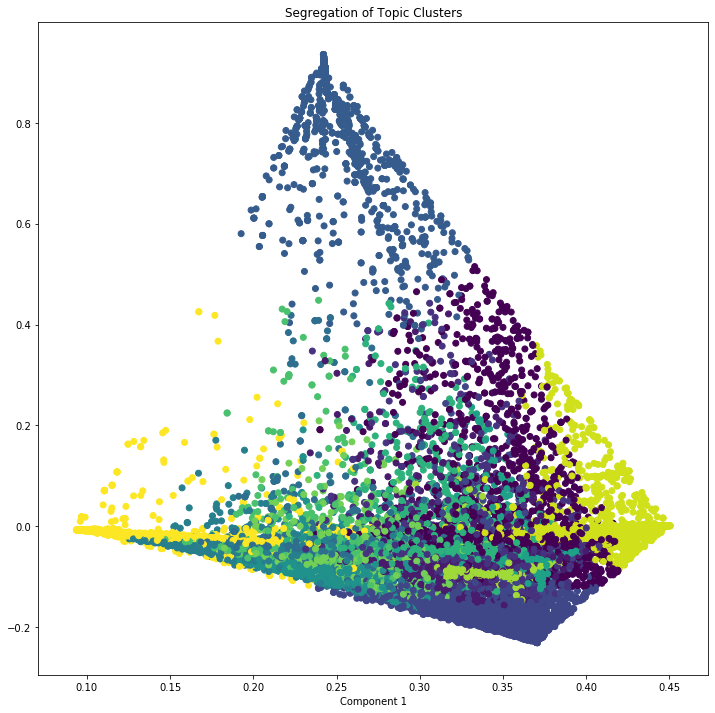

In [56]:
# Plot
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )

In [57]:
#find out how to make in 3D

Other Visualization Examples:
    
https://www.machinelearningplus.com/nlp/topic-modeling-python-sklearn-examples/

**Data Mapper Pipeline**


This allow each column to be mapped to different encoders.

https://pypi.org/project/dataframe-mapper/

In [58]:
!pip install dataframe-mapper

Should do this for title and summary separately:

In [59]:
# column_tuples = [
#     ('Sales', None),
#     ('ShelveLoc', LabelEncoder()),
#     ('Urban', LabelEncoder()), 
#     ('US', LabelEncoder())]

# mapper = DataFrameMapper(column_tuples, default=StandardScaler())
# mapper_fit = mapper.fit(train)

**Save the vectorizer!**

https://stackoverflow.com/questions/29788047/keep-tfidf-result-for-predicting-new-content-using-scikit-for-python

# Adding topics to MySQL:

Create a separate table for topics and link with BillID Primary Key

https://stackoverflow.com/questions/53518217/adding-topic-distribution-outcome-of-topic-model-to-pandas-dataframe

In [60]:
#make sure it is the right shape first!
df.shape

(51067, 6)

In [144]:
engine = db.create_engine(f'mysql+mysqlconnector://{config_final.user}:{config_final.password}@{config_final.host}/con_bills')

connection = engine.connect()
metadata=db.MetaData()

Exception during reset or similar
Traceback (most recent call last):
  File "/Users/melissamunz/anaconda3/lib/python3.7/site-packages/sqlalchemy/pool/base.py", line 680, in _finalize_fairy
    fairy._reset(pool)
  File "/Users/melissamunz/anaconda3/lib/python3.7/site-packages/sqlalchemy/pool/base.py", line 867, in _reset
    pool._dialect.do_rollback(self)
  File "/Users/melissamunz/anaconda3/lib/python3.7/site-packages/sqlalchemy/dialects/mysql/base.py", line 2241, in do_rollback
    dbapi_connection.rollback()
  File "/Users/melissamunz/anaconda3/lib/python3.7/site-packages/mysql/connector/connection_cext.py", line 369, in rollback
    self._cmysql.rollback()
_mysql_connector.MySQLInterfaceError: MySQL server has gone away


In [149]:
#Create Table 
topics_table = db.Table('topics', metadata,               
    db.Column('BillID', db.String(40), primary_key=True),
    db.Column('Topic', db.String(20)),
#     FOREIGN KEY (BillID) REFERENCES current_bills(BillID);                         
)

SyntaxError: invalid syntax (<ipython-input-149-04dea55b225d>, line 5)

In [146]:
# metadata.create_all(engine)

In [63]:
# query = db.insert(topics_table)
# connection.execute(query, bill)